# Introduction to Deep Learning

Please, make a copy of this colaboratory in order to be able to make changes **(File -> Save a copy in Drive)**.


In [58]:
# A bit of setup
import numpy as np
import matplotlib.pyplot as plt

Here we will define few functions that will help us visualise classifiers that we are going to build in this class. Don't worry if you don't understand this code completely.


In [59]:
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
#%load_ext autoreload
#%autoreload 2

# for very shallow models
def plot_classifier(X, y, W, b):
  st = 0.02 # step of our grid of points
  x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
  y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
  xx, yy = np.meshgrid(np.arange(x_min, x_max, st),
                       np.arange(y_min, y_max, st))
  Z = np.dot(np.c_[xx.ravel(), yy.ravel()], W) + b
  Z = np.argmax(Z, axis=1)
  Z = Z.reshape(xx.shape)
  fig = plt.figure()
  plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
  plt.scatter(X[:, 0], X[:, 1], c=y, s=120, edgecolors = 'white', cmap=plt.cm.Spectral)
  plt.xlim(xx.min(), xx.max())
  plt.ylim(yy.min(), yy.max())

# for two-layer network
def plot_neural_network(X, y, W,b ,W2, b2):
  st = 0.02 # step of our grid of points
  x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
  y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
  xx, yy = np.meshgrid(np.arange(x_min, x_max, st),
                       np.arange(y_min, y_max, st))
  Z = np.dot(np.maximum(0, np.dot(np.c_[xx.ravel(), yy.ravel()], W) + b), W2) + b2
  Z = np.argmax(Z, axis=1)
  Z = Z.reshape(xx.shape)
  fig = plt.figure()
  plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
  plt.scatter(X[:, 0], X[:, 1], c=y, s=120, edgecolors = 'white', cmap=plt.cm.Spectral)
  plt.xlim(xx.min(), xx.max())
  plt.ylim(yy.min(), yy.max())

## Let's generate some 2D data like in the lecture


In [60]:
N = 100 # number of points per class
D = 2 # number of features (dimensions)
K = 2 # number of classes (purple and red circles)
X = np.zeros((N*K,D)) # data matrix (each row = single example)
num_examples = X.shape[0]
y = np.zeros((N*K, 1), dtype='int') # class labels

In [61]:
# Creating spiral data points
np.random.seed(1111)

for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix, 0] = j

Lets visualize newly generated data:


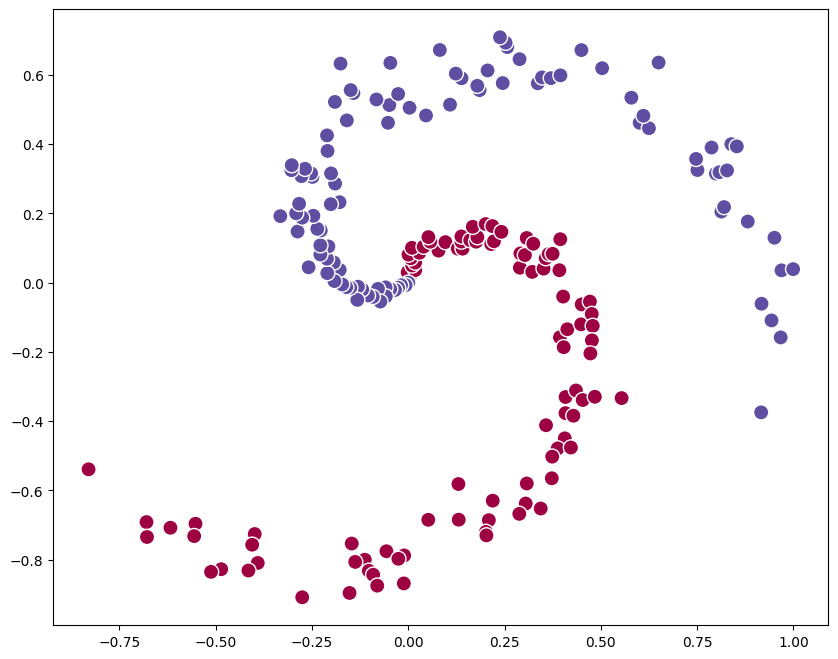

In [62]:
# this is matplotlib...
plt.scatter(X[:, 0], X[:, 1], c=y, s=120, edgecolors = 'white', cmap=plt.cm.Spectral)
plt.show()

For our implementation we would need to transform the vector of correct labels `y` into one hot encoded matrix, let's call it `truth`.


In [63]:
# current labels:
print(y[:,0])

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


creating `truth` as one-hot encoded labels (`y`)


In [64]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')
truth = enc.fit_transform(y).toarray()

# first column is for red
# second is for purple class

In [65]:
print(truth[:5,])

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


The first five points are red


In [66]:
print(truth[-5:,])

[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [67]:
# 0 index is red
# 1 index is purple


## Step by step training two artificial neurons

Here we create one neuron per each class, with biases, but **without activation function**. Note that we initialize the weights from standard normal distribution, but then scale them down with 0.01, because if the weights are too large, we might get an exploding gradient problem later.


In [68]:
np.random.seed(1111)
# initialize weights randomly and bias to be zero
W = 0.01 * np.random.randn(D,K)  # Normal distribution -1 to 1 and SD 1, EX = 0
b = np.zeros((1,K))

### Feed-forward path


Compute the predictions by multiplying inputs $X$ with weights $W$ and adding biases $b$.


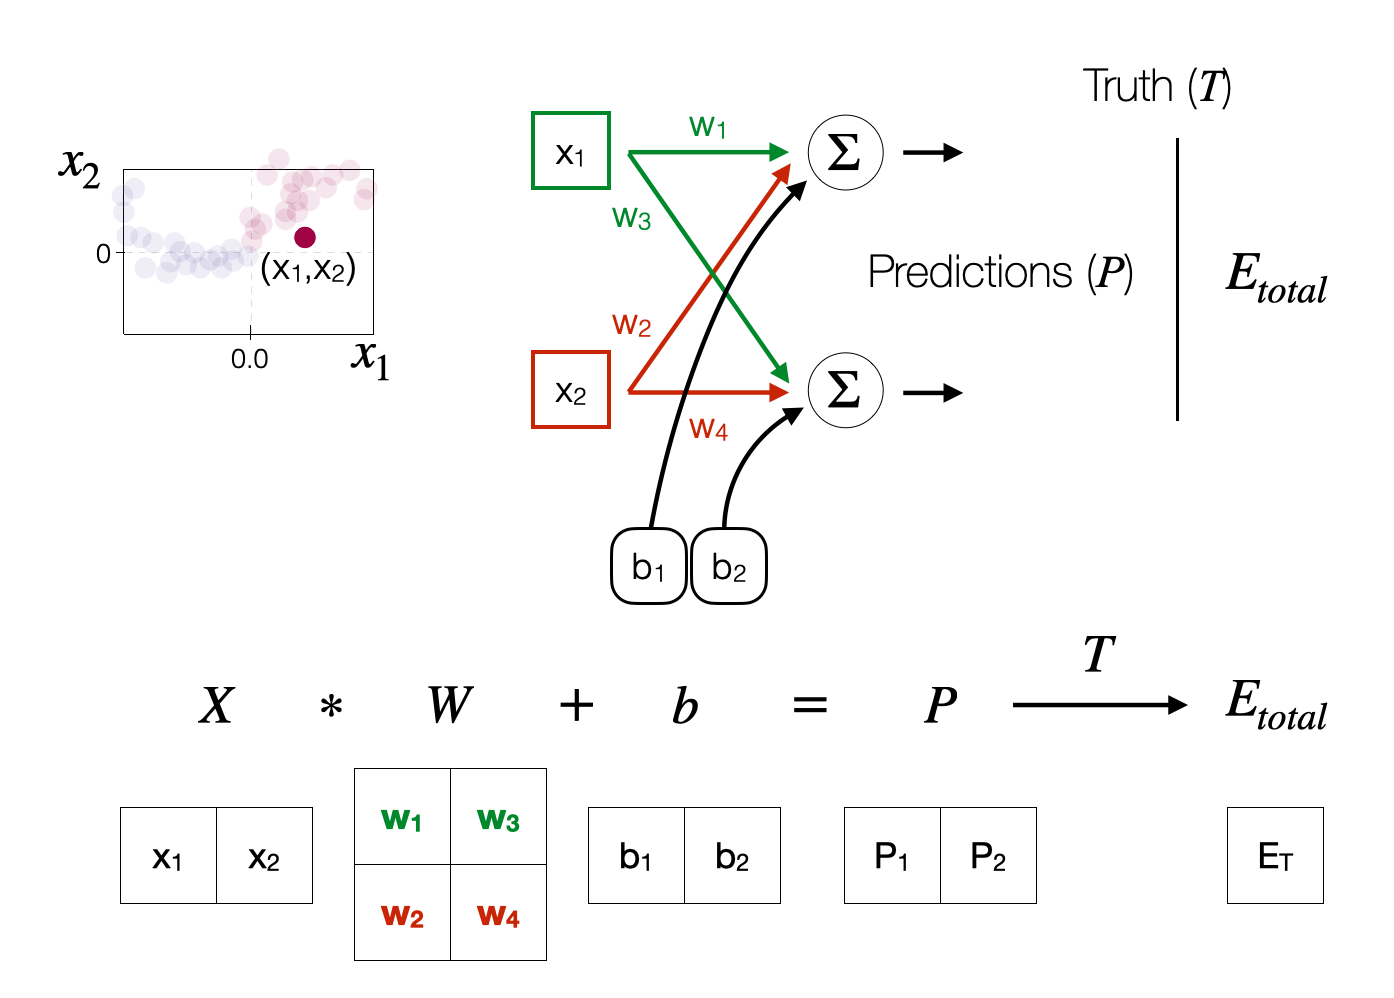


In [69]:
##### YOUR CODE STARTS #####
predictions = X @ W + b
##### YOUR CODE ENDS #####

In [70]:
print(f'{X.shape} x {W.shape} = ({X.shape[0]},{W.shape[1]})')

(200, 2) x (2, 2) = (200,2)


In [71]:
print(predictions.shape)

(200, 2)


In [72]:
print(np.round(predictions[0:5], 4))

[[ 0.      0.    ]
 [ 0.0001 -0.0001]
 [ 0.0001 -0.0002]
 [ 0.0003 -0.0002]
 [ 0.0001 -0.0005]]


As we now have the predictions, let's compute the $E_{total}$ denoted as `total_error`. Here we will use the same mean squared error (MSE) as in the lecture.


In [73]:
##### YOUR CODE STARTS #####
# MSE - Not correct here!!! (predictions - truth) ** 2


total_error = 0.5 * np.sum((predictions - truth) ** 2) # Divide by 2 - we get a derivateve and we get rid of square roots
##### YOUR CODE ENDS #####
total_error = total_error/num_examples # to complete the MSE
print("Total error: {0}".format(total_error))

Total error: 0.5039424512576577


Let's plot the result of our classification. The colour of the background represents `predictions` ($P$) and colour of points reflects the true classes, `truth` ($T$).


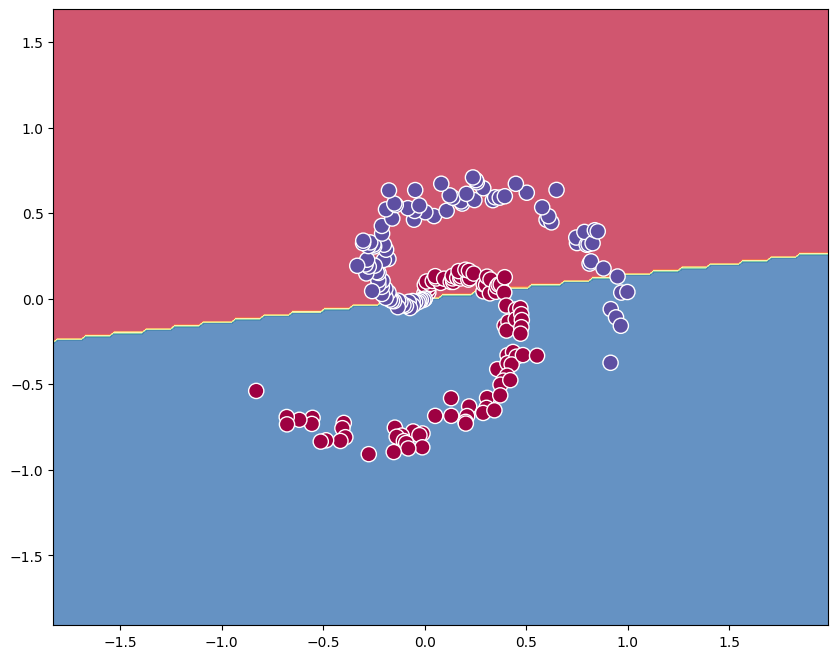

In [74]:
plot_classifier(X, y, W, b)

### Backpropagation


Now, as we have calculated the $E_{total}$, we can proceed to minimize it via gradient descent. We will start with estimating the effects of $W$ on $E_{total}$, which is $\frac{\partial{E_{total}}}{\partial{W}}$.


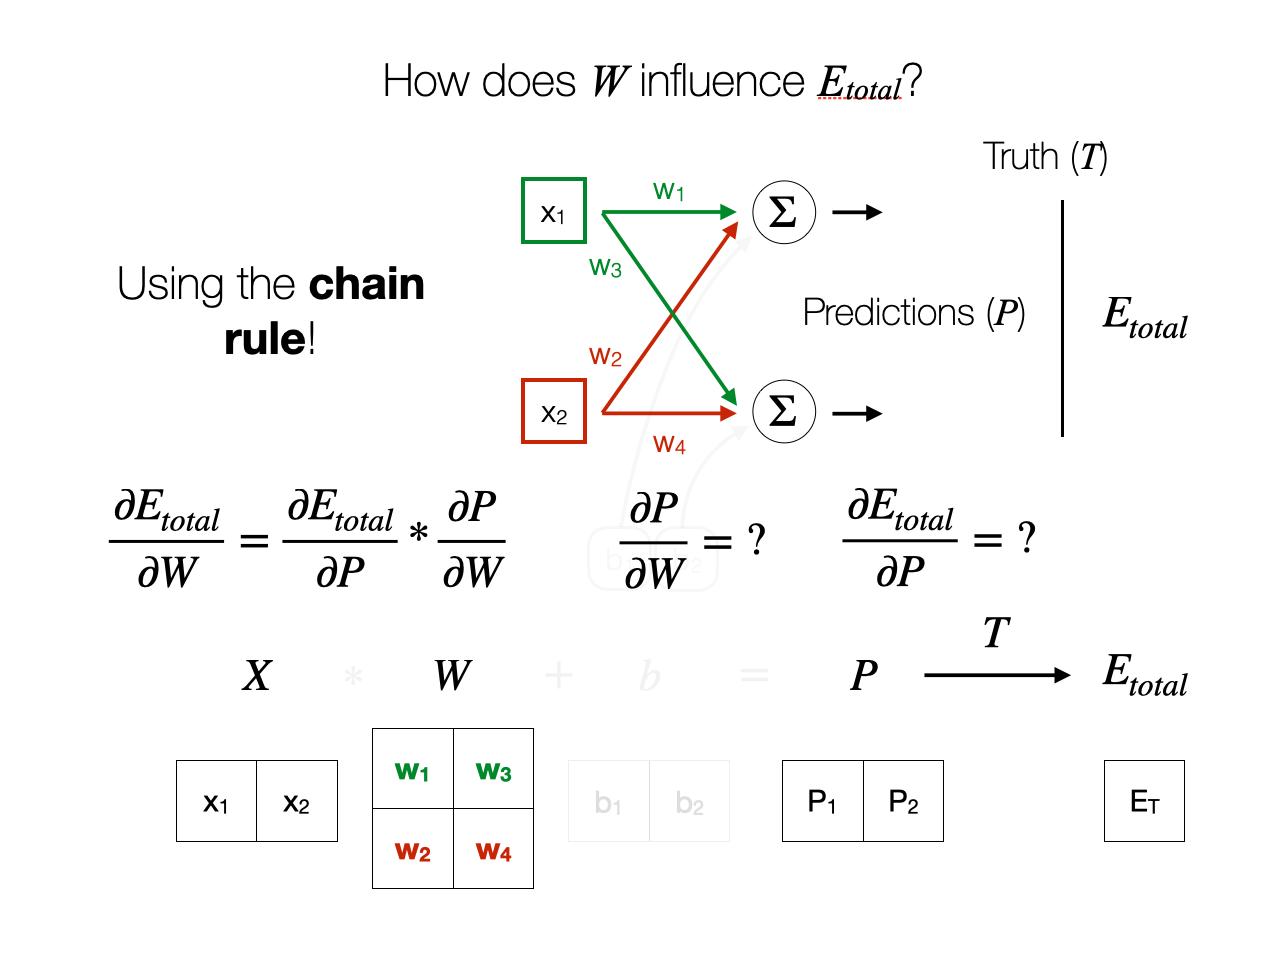


We should start with $\frac{\partial{E_{total}}}{\partial{P}}$. Remind yourselves that $E_{total} = \frac{1}{2}(truth - predictions)^2$, if we want to find we need to take partial derivative of this equation with respect to $P$, i.e. $\frac{\partial{E_{total}}}{\partial{P}} = \frac{1}{2}(truth - predictions)\cdot2\cdot(-1)$

We will use variable **`dTEdP`** (TE stands for total error) to denote this derivative.


In [75]:
##### YOUR CODE STARTS #####
# Estimate the gradient - how much the error will change if we change W
# How W affects E_total

dTEdP = predictions - truth # WTF???? i dont get it
##### YOUR CODE ENDS #####
dTEdP /= num_examples

In [76]:
dTEdP.shape

(200, 2)

Let's recall that $P = XW + \bar{b}$. According to deriviations presented [here](http://cs231n.stanford.edu/handouts/linear-backprop.pdf):
$$\frac{\partial{P}}{\partial{W}}=X^{T}$$
<br>

Let's calculate $$\frac{\partial{P}}{\partial{W}}$$, which will be denoted by `dPdW`.


In [77]:
##### YOUR CODE STARTS #####
dPdW = X.T
##### YOUR CODE ENDS #####

In [78]:
dPdW.shape

(2, 200)

Now it is a time to put both parts together and calculate $\frac{\partial{E_{total}}}{\partial{W}}$, we will denote this value using `dW` to make it shorter.

**Hint**: Remember that multiplication $\frac{\partial{E_{total}}}{\partial{P}}$ by $\frac{\partial{P}}{\partial{W}}$ will not work. Why?


In [79]:
# we are expecting 2x2 matrix, same shape as W

In [80]:
dTEdP.shape

(200, 2)

In [81]:
dPdW.shape

(2, 200)

In [82]:
##### YOUR CODE STARTS #####
dW = dPdW @ dTEdP
##### YOUR CODE ENDS #####

In [83]:
dW.shape

(2, 2)

What else is there? Biases!


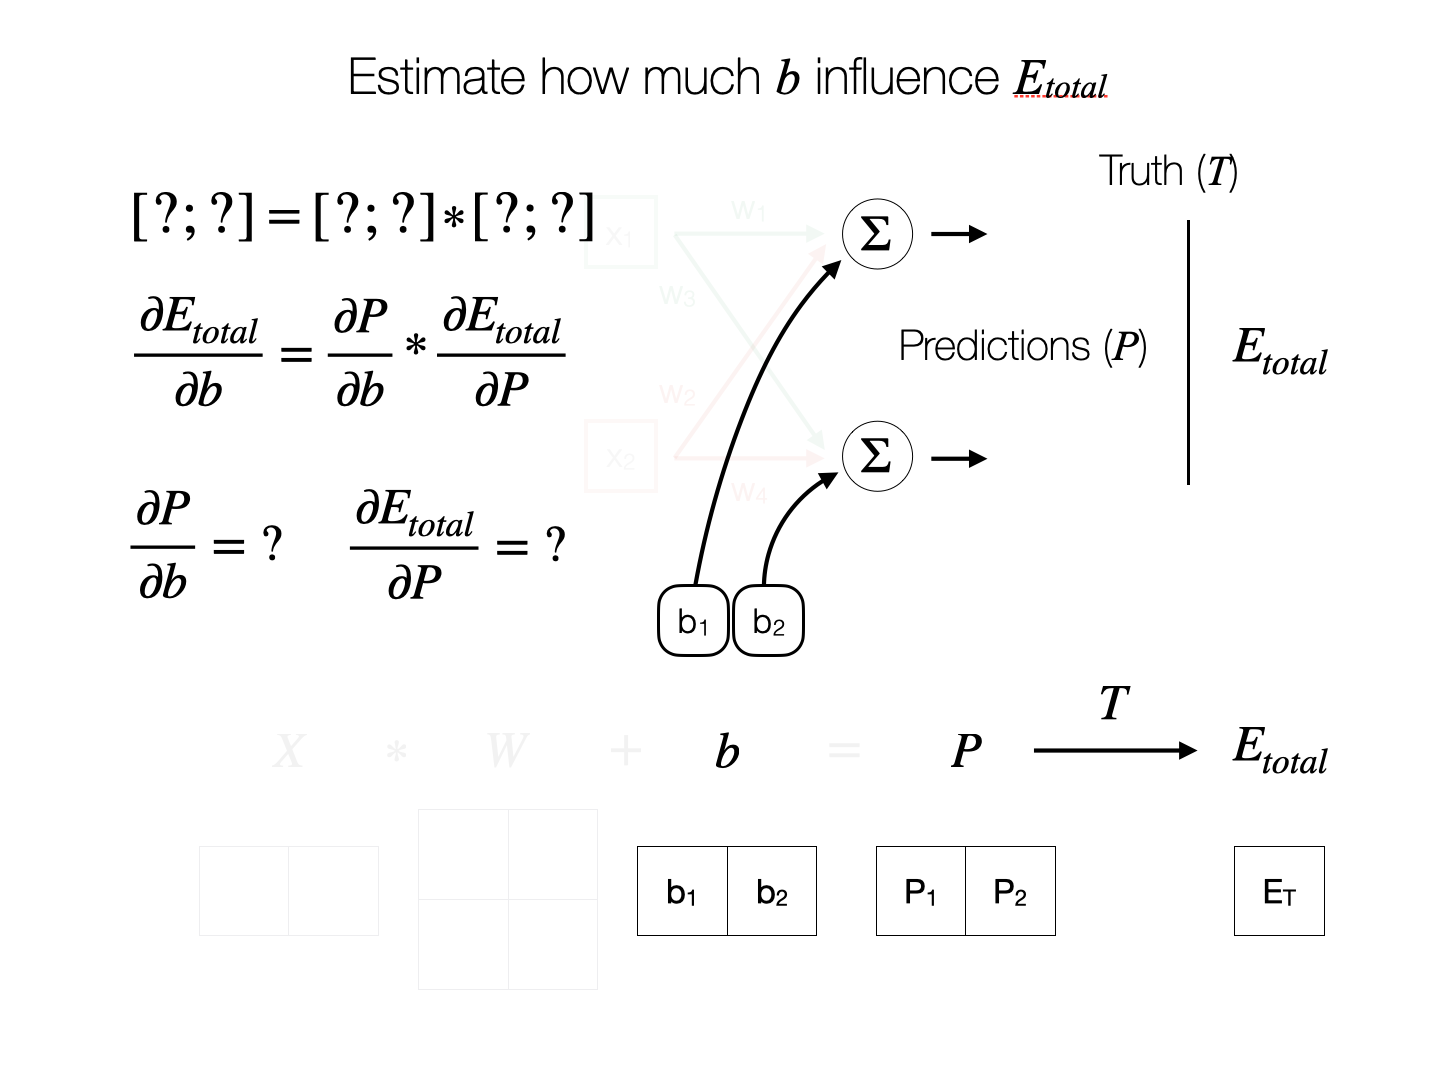


What about $\frac{\partial{E_{total}}}{\partial{P}}$? We have already calculated it, check `dTEdP`. What is left is $\frac{\partial{P}}{\partial{b}}$, since we remember that $P = X \times W + b$, taking a partial derivative with respect to $b$ will not be a problem?


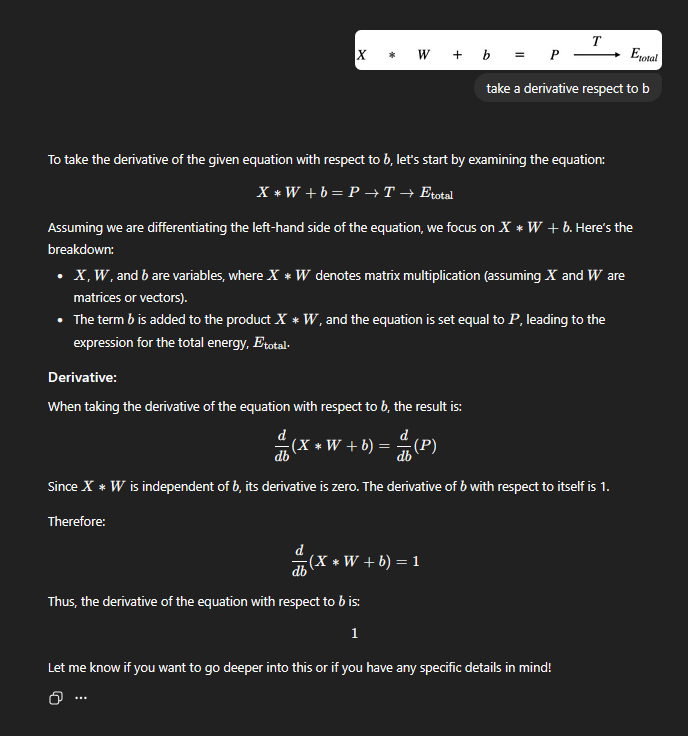
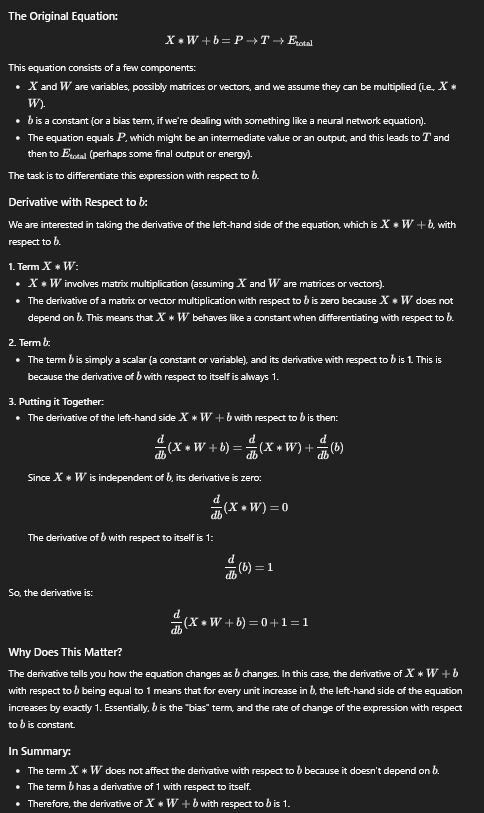
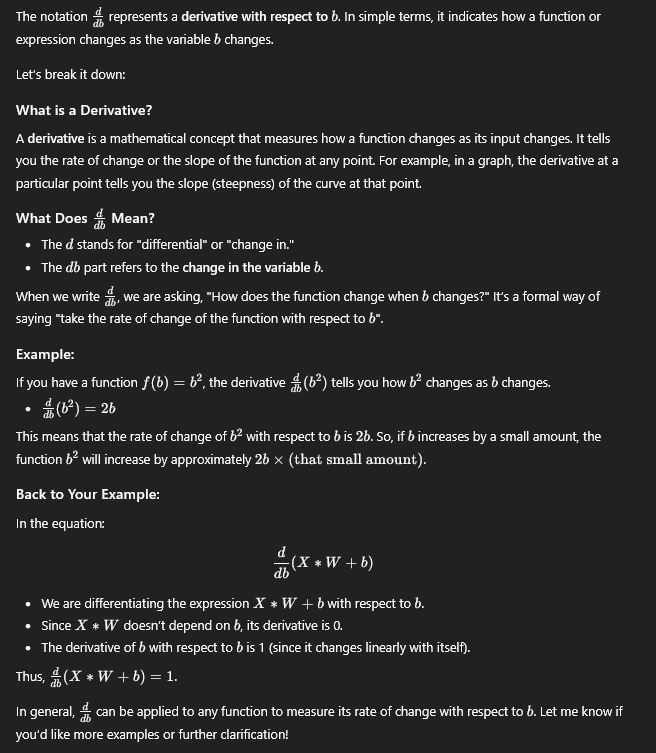


In [84]:
##### YOUR CODE STARTS #####
# Bias derivative!!!!!

dPdb = 1
##### YOUR CODE ENDS #####

Now, let's calculate $\frac{\partial{E_{total}}}{\partial{b}}$, denoted as **`db`**.


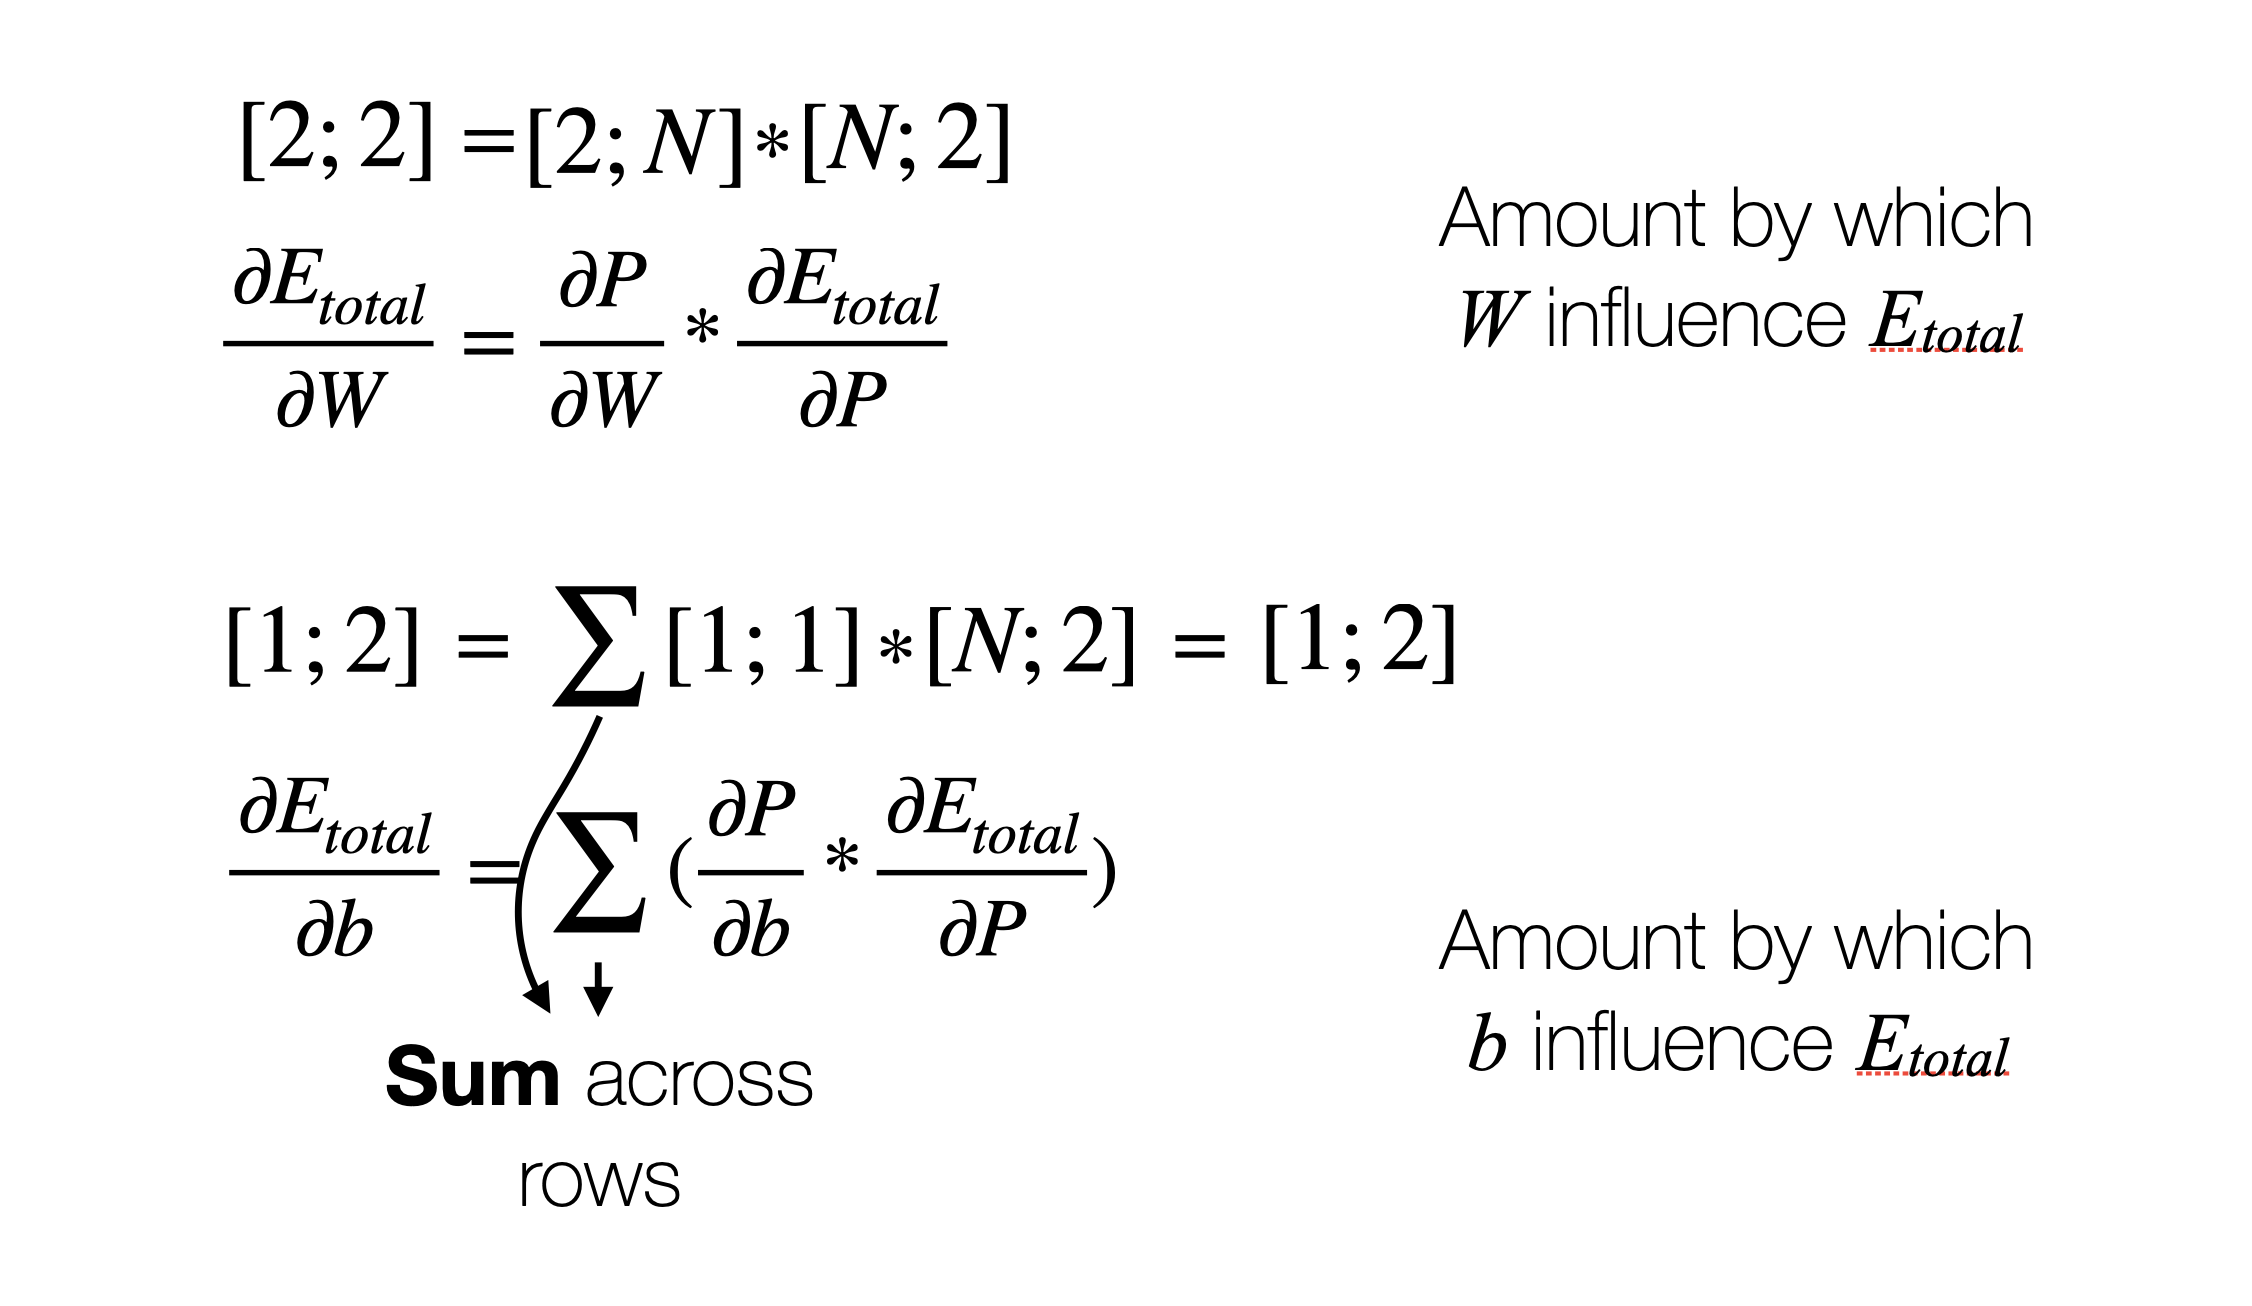


In [85]:
##### YOUR CODE STARTS #####
db = np.sum(dTEdP, axis = 0, keepdims = True)
##### YOUR CODE ENDS #####

In [86]:
db

array([[-0.50170289, -0.50135413]])

In [87]:
print(f"Updates for W and b are {np.round(dW, 2)} and {np.round(db, 2)}")

Updates for W and b are [[-0.06 -0.07]
 [ 0.15 -0.14]] and [[-0.5 -0.5]]


Update old **`W`** and **`b`** using calculated **`dW`** and **`db`**.

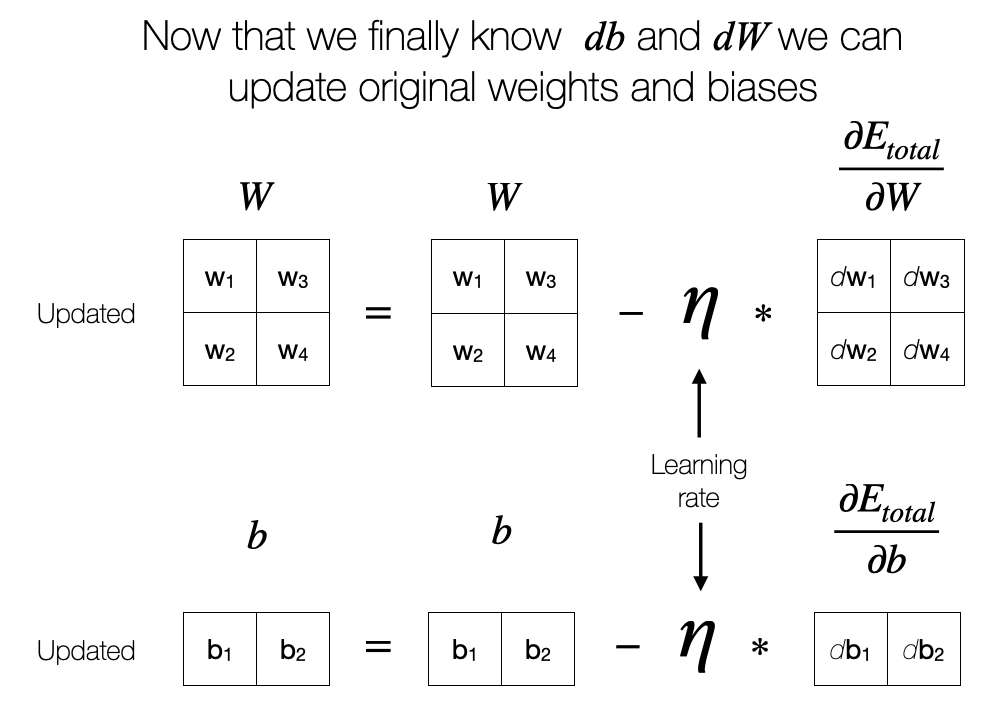


In [88]:
# perform a parameter update
learning_rate = 1

##### YOUR CODE STARTS #####
W = W - learning_rate*dW
b = b - learning_rate*db
##### YOUR CODE ENDS #####

In [89]:
b, W

(array([[0.50170289, 0.50135413]]),
 array([[ 0.04795198,  0.0608482 ],
        [-0.1381489 ,  0.13489261]]))

New decision boundary now looks as follows:


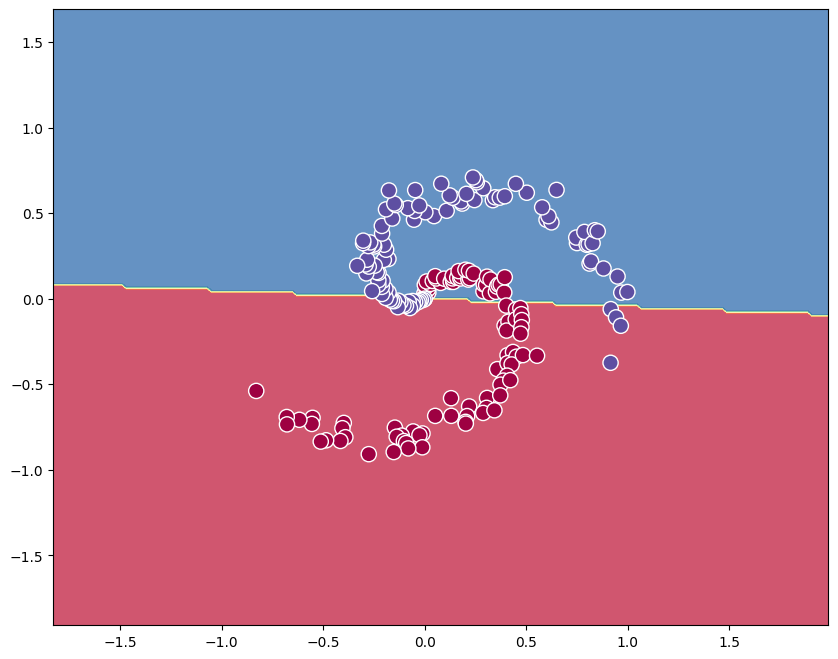

In [90]:
plot_classifier(X, y, W, b)

In [91]:
predictions = X @ W + b

total_error = 0.5 * np.sum((predictions - truth) ** 2)
total_error = total_error/num_examples

In [92]:
print("Total error: {0}".format(total_error))

print(predictions[0:5])

Total error: 0.21477452941660802
[[0.50170289 0.50135413]
 [0.50024462 0.50258954]
 [0.49922042 0.5042927 ]
 [0.49744369 0.5053354 ]
 [0.49756981 0.50732882]]


## Putting this all together: Training a linear classifier


In [ ]:
# initialize parameters randomly
W = 0.01 * np.random.randn(D,K)
b = np.zeros((1,K))

# some hyperparameters
learning_rate = 1

# gradient descent loop
num_examples = X.shape[0]
for i in range(200):

  ##### YOUR CODE STARTS #####

  # evaluate predictions, [N x K]
  predictions = X @ W + b

  # compute the error: average sum of squared differences
  total_error = 0.5*np.sum((truth - predictions)**2)
  total_error = total_error/num_examples # we need to normalise the error over all examples, to keep things stable

  if i % 10 == 0:
    print("iteration %d: loss %e" % (i, total_error))

  # compute the gradient on predictions
  dTEdP = predictions - truth
  dTEdP /= num_examples

  # compute the gradient on weights and biases
  dPdW = X.T
  dPdb = 1

  # complete backpropatation path to the parameters (W,b)
  dW = dPdW @ dTEdP
  db = np.sum(dTEdP, axis = 0, keepdims = True)

  # perform a parameter update
  W = W - learning_rate*dW # We use * here and not @ because its scalar multiplication
  b = b - learning_rate*db
  ##### YOUR CODE ENDS #####

iteration 0: loss 5.009235e-01
iteration 10: loss 1.389874e-01
iteration 20: loss 1.356439e-01
iteration 30: loss 1.354198e-01
iteration 40: loss 1.354006e-01
iteration 50: loss 1.353989e-01
iteration 60: loss 1.353987e-01
iteration 70: loss 1.353987e-01
iteration 80: loss 1.353987e-01
iteration 90: loss 1.353987e-01
iteration 100: loss 1.353987e-01
iteration 110: loss 1.353987e-01
iteration 120: loss 1.353987e-01
iteration 130: loss 1.353987e-01
iteration 140: loss 1.353987e-01
iteration 150: loss 1.353987e-01
iteration 160: loss 1.353987e-01
iteration 170: loss 1.353987e-01
iteration 180: loss 1.353987e-01
iteration 190: loss 1.353987e-01


In [123]:
# evaluate the final accuracy
predictions = X @ W + b
predicted_class = np.argmax(predictions, axis=1)
print('training accuracy: %.2f' % (np.mean(predicted_class == y[:,0])))

training accuracy: 0.77


This should produce something like ~**77%**. Not very good at all, but also not surprising given that the dataset is constructed so it is not linearly separable. We can also plot the learned decision boundaries. Btw, see if you can interpret this plot.


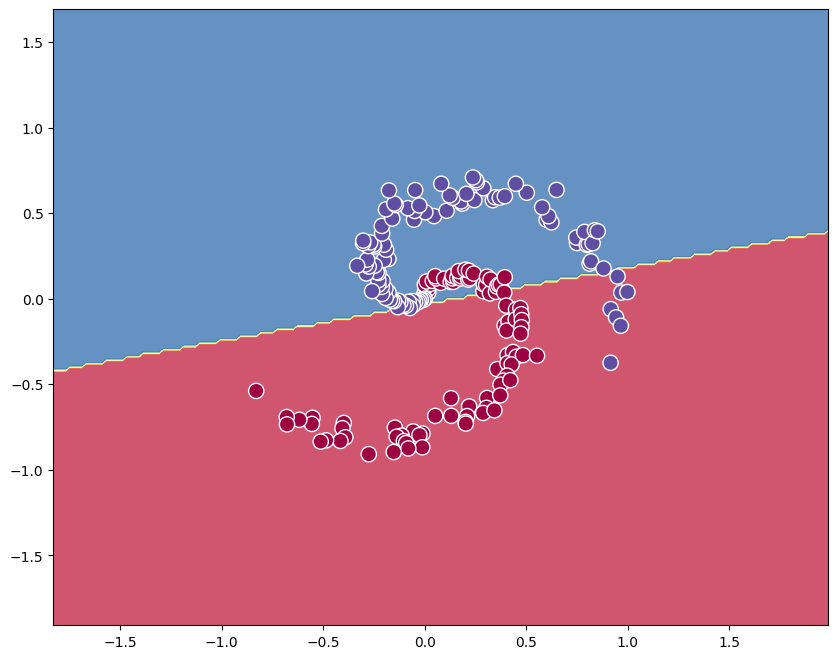

In [124]:
plot_classifier(X, y, W, b)

## Training a simple Neural Network


Clearly, one layer is not enough for this dataset and we would like to use a **deeper neural network**. One additional hidden layer will suffice for this toy data. We will now need two sets of weights and biases (for the first and second layers).


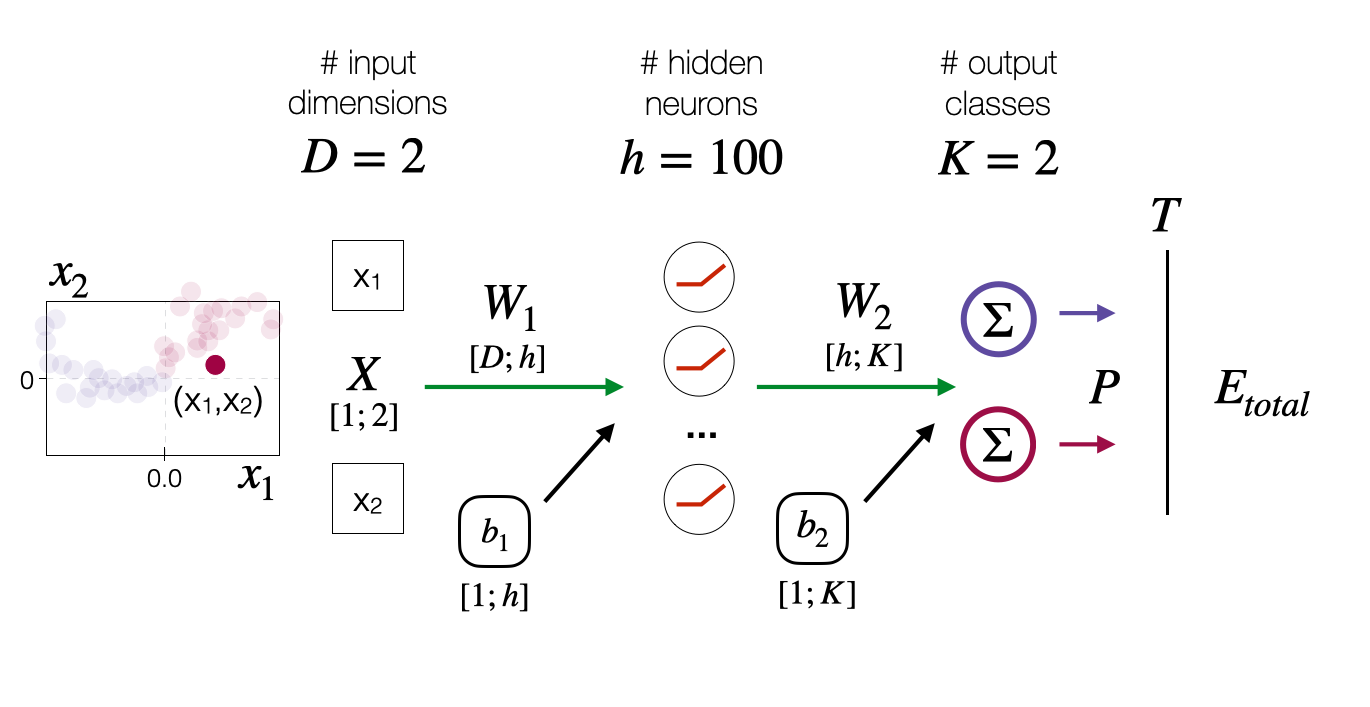


In [129]:
np.random.seed(1111)

# initialize parameters randomly
h = 100 # number of neurons in the hidden layer

# first hidden layer
W1 = 0.01 * np.random.randn(D,h)
b1 = np.zeros((1,h))

### Feed-forward path


In [ ]:
# Relu removes all negative values!!!

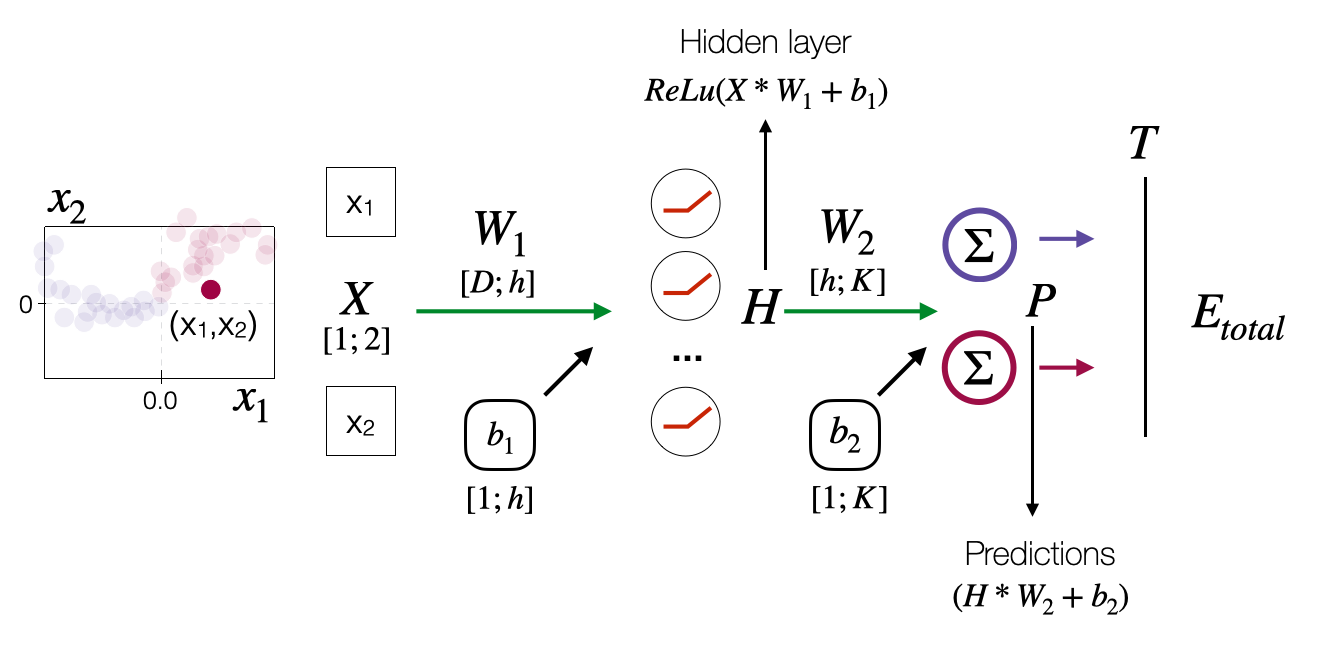


Let's calculate the input to the hidden layer, denoted as `hidden_layer`. There are actually two parts for the hidden layer: the values before and after activation. To make the backpropagation part (we'll get to that a bit later) very clear, we denote them with separate variables. So the `hidden_layer` consists of values before activation (`H`) and values after applying the activation function (`H_act`).


In [130]:
H = X @ W1 + b1

In [131]:
H.shape

(200, 100)

In this network we will use activation function (**ReLu**), which thresholds the activations in the hidden layer at zero.


In [132]:
##### YOUR CODE STARTS #####
H_act = np.maximum(0, H) # NB! ReLU activation
##### YOUR CODE ENDS #####

What are the dimensions of the second layer? We have 100 neurons in the hidden layer and 2 neurons in the output layer. Therefore we need 100 x 2 connections (weights) between these two layers.


In [136]:
np.random.seed(1111)

# initialize the second (output) layer
W2 = 0.01 * np.random.randn(h,K)
b2 = np.zeros((1,K))

Let's compute predictions as before but now using a 2-layer (one hidden layer + one output layer) network:


In [137]:
##### YOUR CODE STARTS #####
predictions = H_act @ W2 + b2 # Note, no activation function for the second layer!
##### YOUR CODE ENDS #####

In [138]:
print(np.round(predictions[0:5], 6))

[[ 0.0e+00  0.0e+00]
 [ 9.0e-06 -1.0e-06]
 [ 1.5e-05 -7.0e-06]
 [ 2.6e-05 -5.0e-06]
 [ 2.5e-05 -1.6e-05]]


### Backpropagation


Note, we first compute the hidden layer representation and then the `predictions` using output of the first layer and weights of the second layer. Everything else remains the same. We compute the error based on the predictions exactly as before, and get the gradient for the predictions `dTEdP` exactly as before.


In [139]:
dTEdP = predictions - truth
dTEdP /= num_examples

In [140]:
dTEdP.shape

(200, 2)

However, the way we backpropagate that gradient into the model parameters now changes, of course. First lets backpropagate into the second layer of the network.


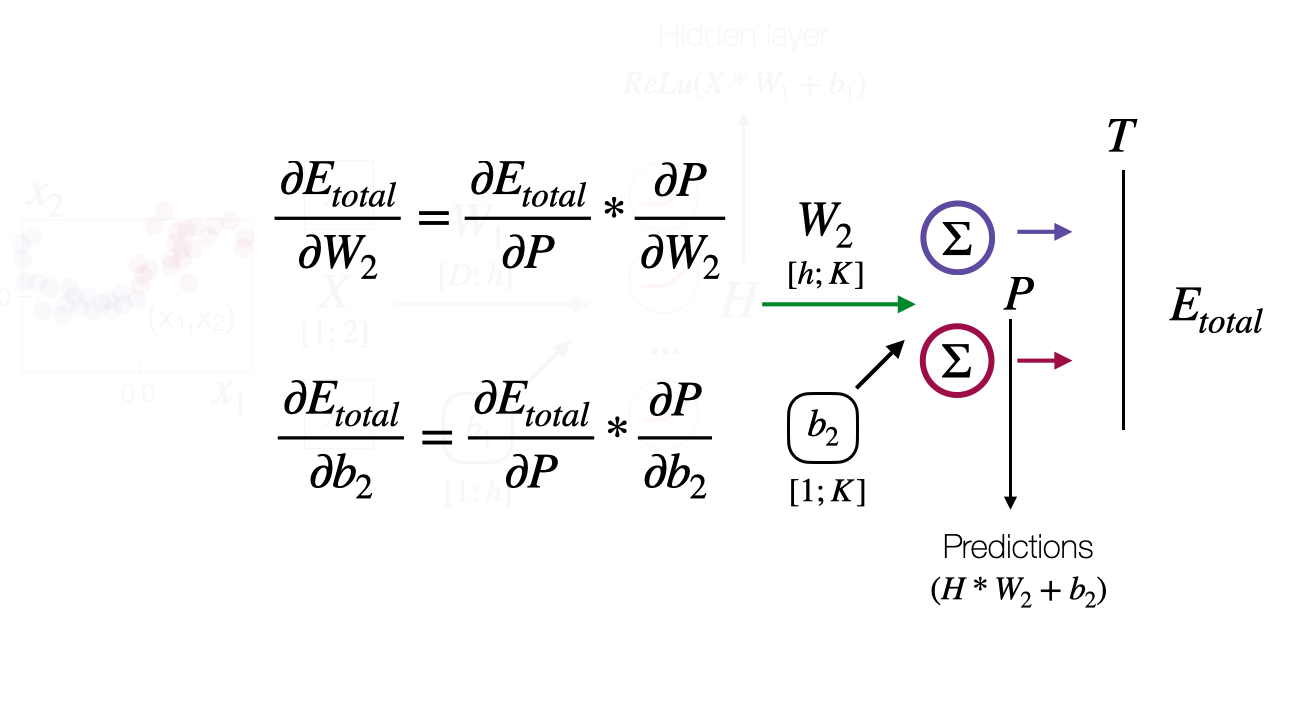


Remind yourself that predictions ($P$) are obtained by $H_{act} * W_2 + b_2$. Figure out how to compute $\frac{\partial{P}}{\partial{W_2}}$ and $\frac{\partial{P}}{\partial{b_2}}$ below:


In [105]:
##### YOUR CODE STARTS #####
dPdW2 = H_act.T
dPdb2 = 1
##### YOUR CODE ENDS #####

Now let's compute updates for $W_2$ and $b_2$ using earlier computed $\frac{\partial{E_{total}}}{\partial{P}}$, $\frac{\partial{P}}{\partial{W_2}}$ and $\frac{\partial{P}}{\partial{b_2}}$.


In [106]:
dW2 = dPdW2 @ dTEdP
db2 = np.sum(dTEdP, axis = 0, keepdims=True)

Since, we have two layers in our network, we also need to update $W_1$ and $b_1$. However, these variables do not directly contribute to predictions, they do it via the **`hidden_layer`**.


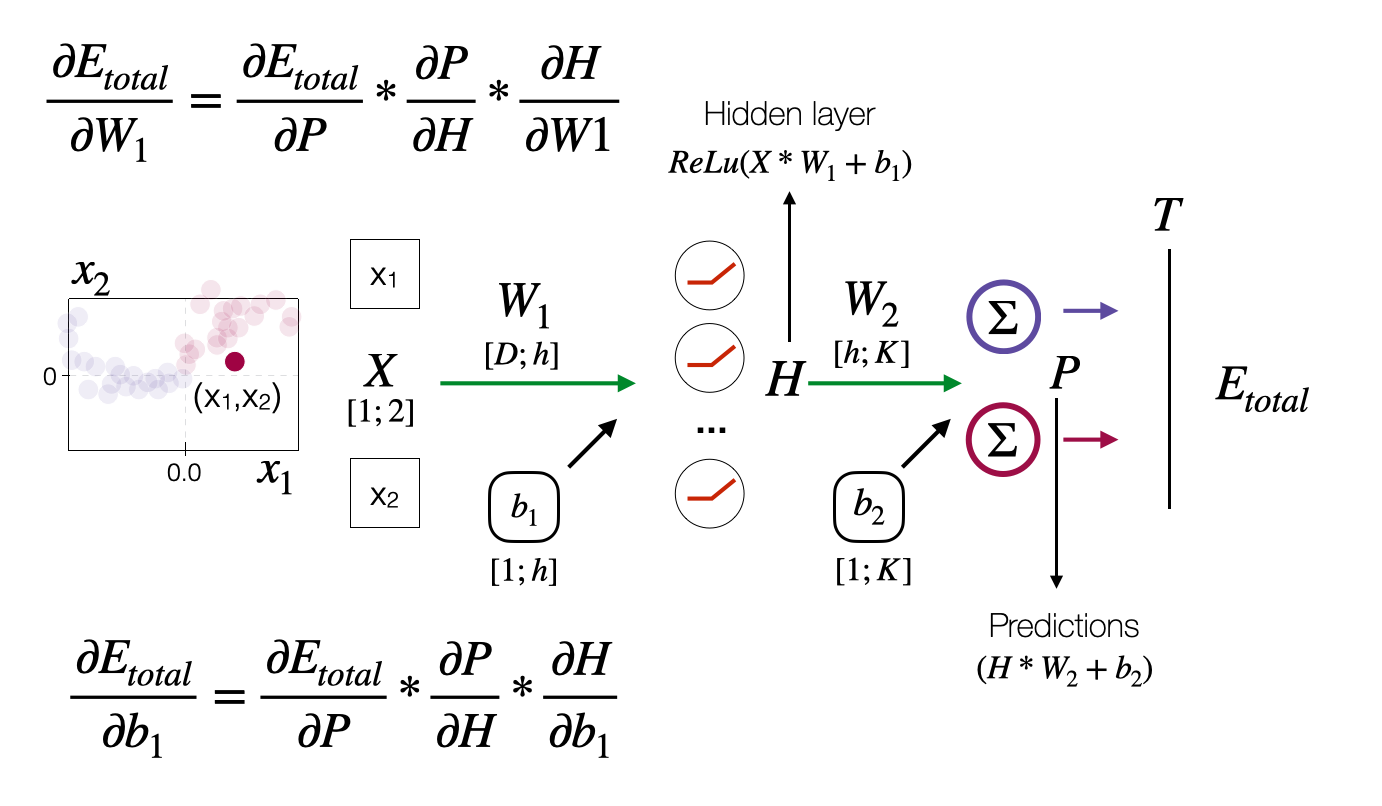


In order to understand what to do next, think how chain rule will look like for $W_1$ and $b_1$. For exampel for $W_1$ it should be $\frac{\partial{E_{total}}}{\partial{W_1}} = \frac{\partial{E_{total}}}{\partial{P}} * \frac{\partial{P}}{\partial{H_{act}}} * \frac{\partial{H_{act}}}{\partial{H}} * \frac{\partial{H}}{\partial{W_1}}$. Hence, we need to continue backpropagation through this variable. Remind yourself that $P = (H_{act} * W_2 + b_2)$ and now find $\frac{\partial{P}}{\partial{H_{act}}}$ denoted as `dPdH_act`:


In [107]:
##### YOUR CODE STARTS #####
dPdH_act = W2.T
##### YOUR CODE ENDS #####

We can save intermediate progress, namely $\frac{\partial{E_{total}}}{\partial{P}} * \frac{\partial{P}}{\partial{H_{act}}}$ into variable `dH_act`.


In [108]:
dTEdP.shape

(200, 2)

In [109]:
dPdH_act.shape

(2, 100)

In [110]:
dH_act = dTEdP @ dPdH_act

Now we have the gradient on the outputs of the hidden layer. Next, we have to backpropagate the ReLU non-linearity. This turns out to be easy because ReLU during the backward pass is effectively a switch. Therefore, ReLU unit lets the gradient pass through unchanged (multiplied by 1) if its input was greater than 0, but kills it if its input was less than zero during the forward pass.


In [111]:
# backprop the ReLU non-linearity
dH = dH_act.copy()
dH[H_act <= 0] = 0

And now we finally continue to the first layer weights and biases. Just remind yourself that $H = X * W_1 + b_1$ and you are looking for $\frac{\partial{H}}{\partial{W_1}}$ and $\frac{\partial{H}}{\partial{b_1}}$:


In [142]:
dW1 = X.T @ dH
db1 = np.sum(dH, axis=0, keepdims=True)

The full code looks very similar to what we have written before:


In [143]:
# initialize parameters randomly
h = 100 # size of hidden layer
W1 = 0.01 * np.random.randn(D,h)
b1 = np.zeros((1,h))
W2 = 0.01 * np.random.randn(h,K)
b2 = np.zeros((1,K))

# some hyperparameters
learning_rate = 1e-0

# gradient descent loop
num_examples = X.shape[0]
for i in range(2000):

  # evaluate predictions, [N x K]
  H = X @ W1 + b1
  H_act = np.maximum(0, H)
  predictions = H_act @ W2 + b2

  # compute the error: average sum of squared differences
  total_error = 0.5 * np.sum((truth - predictions)**2)
  total_error /= num_examples

  if i % 100 == 0:
    print("iteration %d: loss %e" % (i, total_error))

  # compute the gradient on predictions
  dTEdP = predictions - truth
  dTEdP /= num_examples

  # backpropate the gradient to the parameters
  # first backprop into parameters W2 and b2
  dW2 = H_act.T @ dTEdP
  db2 = np.sum(dTEdP, axis = 0, keepdims=True)

  # next backprop into hidden layer
  dPdH_act = W2.T
  dH_act = dTEdP @ dPdH_act

  # backprop the ReLU non-linearity
  dH = dH_act.copy()
  dH[H_act <= 0] = 0

  # finally into W1,b1
  dW1 = X.T @ dH
  db1 = np.sum(dH, axis = 0, keepdims=True)

  # perform a parameter update
  W1 = W1 - learning_rate*dW1
  b1 = b1 - learning_rate*db1
  W2 = W2 - learning_rate*dW2
  b2 = b2 - learning_rate*db2

iteration 0: loss 5.001576e-01
iteration 100: loss 1.319648e-01
iteration 200: loss 8.111718e-02
iteration 300: loss 7.069602e-02
iteration 400: loss 6.324878e-02
iteration 500: loss 6.980797e-02
iteration 600: loss 8.019297e-02
iteration 700: loss 8.160864e-02
iteration 800: loss 8.097022e-02
iteration 900: loss 8.036993e-02
iteration 1000: loss 8.033629e-02
iteration 1100: loss 8.111088e-02
iteration 1200: loss 7.940876e-02
iteration 1300: loss 7.916198e-02
iteration 1400: loss 8.000501e-02
iteration 1500: loss 8.006212e-02
iteration 1600: loss 8.013365e-02
iteration 1700: loss 7.963947e-02
iteration 1800: loss 7.946294e-02
iteration 1900: loss 7.915884e-02


In [144]:
# evaluate training set accuracy
hidden_layer = np.maximum(0, (X @ W1 + b1))
predictions = hidden_layer @ W2 + b2
predicted_class = np.argmax(predictions, axis=1)
print('training accuracy: %.2f' % (np.mean(predicted_class == y[:,0])))

training accuracy: 0.94


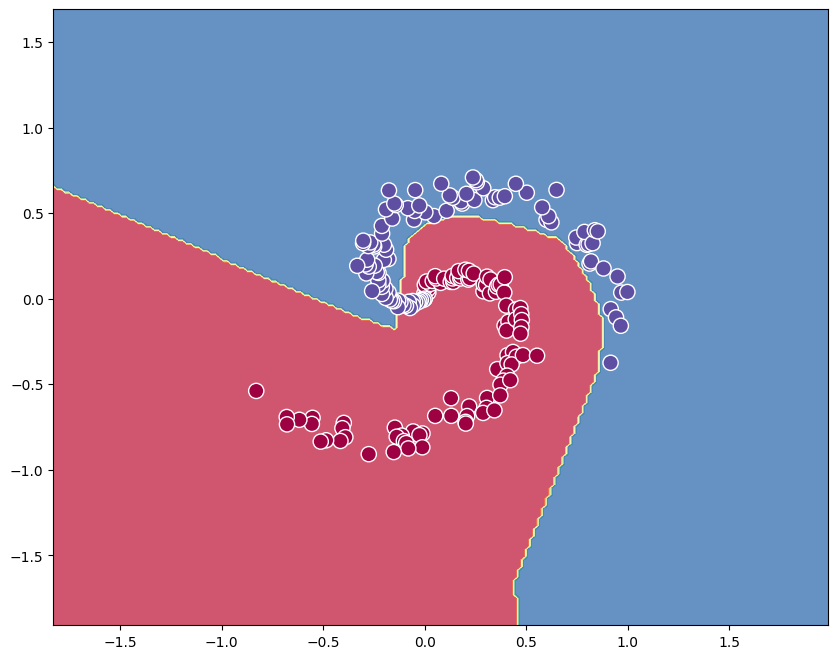

In [145]:
# plot the resulting classifier
plot_neural_network(X, y, W1, b1, W2, b2)

## Using Keras

Of course there is an elephant in the room. Nobody uses pure Python to implement Neural Networks these days. So let's see how the same very simple 2-layer architecture is designed in Keras with way fewer lines of code.

[Keras](https://keras.io/) is a high-level neural networks constructor, written on top of TensorFlow. Keras has very well designed API, which allows for concise code and flexibility at the same time.


In [146]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

Here is how you build a 2-layer neural network with 100 neurons in the hiddel layer in Keras:


In [147]:
h = 100
model = Sequential() # let's us define the network layer by layer
model.add(Dense(h, input_dim=2, activation='relu')) # hidden layer
model.add(Dense(K, activation='sigmoid')) # as many neurons as there are classes

C:\Users\Saskia\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [148]:
# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [149]:
# Run the model
history = model.fit(X, truth, epochs=150, batch_size=10)

Epoch 1/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6350 - loss: 0.6793   
Epoch 2/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7250 - loss: 0.6230 
Epoch 3/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7450 - loss: 0.5733 
Epoch 4/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7400 - loss: 0.5299 
Epoch 5/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7450 - loss: 0.4892 
Epoch 6/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7450 - loss: 0.4540 
Epoch 7/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7600 - loss: 0.4248 
Epoch 8/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7600 - loss: 0.4023 
Epoch 9/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7550 - loss: 0.3849 
Epoch 10/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7650 - loss: 0.3677 
Epoch 11/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7650 - loss: 0.3571 
Epoch 12/150
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/ste

In [150]:
# evaluate the model
scores = model.evaluate(X, truth)
print(f"Accuracy is {scores[1]*100}%")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9900 - loss: 0.0586  
Accuracy is 99.00000095367432%


1086/1086 ━━━━━━━━━━━━━━━━━━━━ 1s 595us/step


(-1.9086612864677124, 1.6913387135322908)

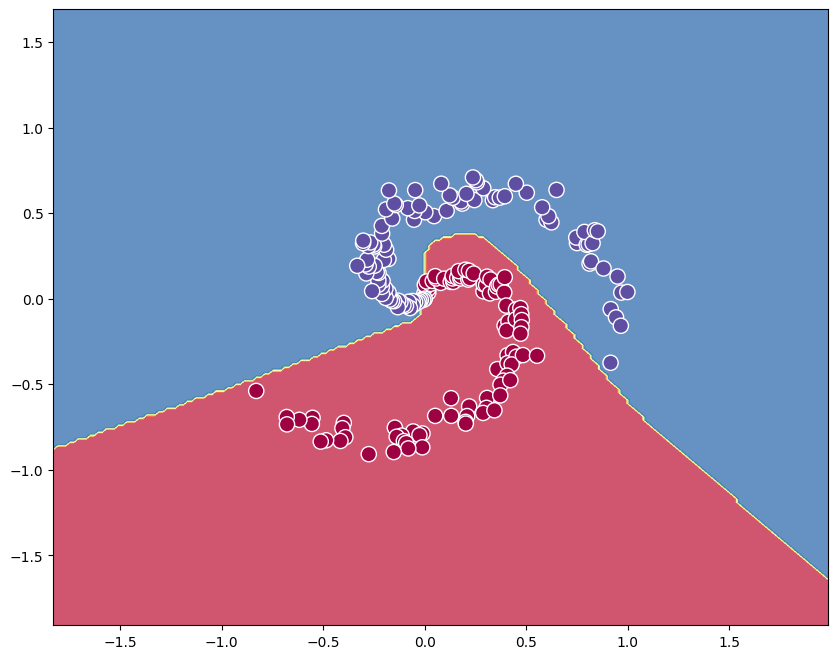

In [151]:
# plot the resulting classifier
h = 0.02
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
Z = np.argmax(Z, axis=1)
Z = Z.reshape(xx.shape)
fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=120, edgecolors = 'white', cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

As we kept records of the learning process in the `history` variable, we now can visualise the dynamics of the training process by plotting loss at different epochs:


Text(0.5, 1.0, 'Loss across epochs')

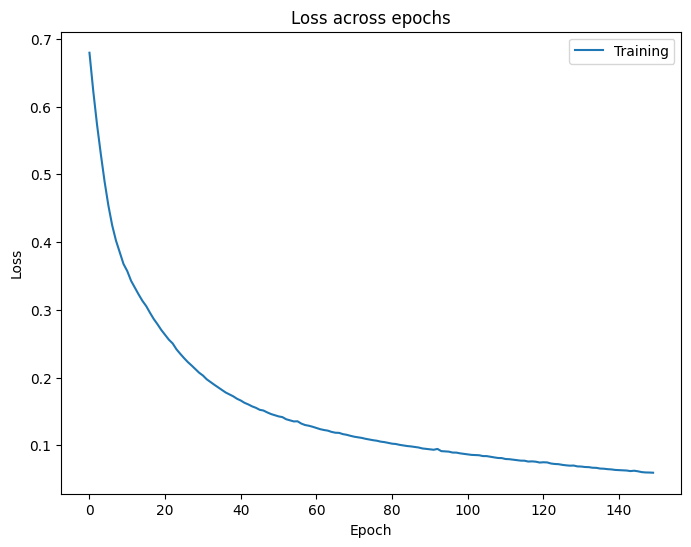

In [152]:
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training'])
plt.title('Loss across epochs')

# References

-   A very large part of this notebook has been inspired by http://cs231n.github.io/neural-networks-case-study/ developed by karpathy@cs.stanford.edu.
